In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from snorkel.models import candidate_subclass

#Title = candidate_subclass('Person_Org', ['person1','Org'])

from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'Emails Training Candidates').one()
dev = session.query(CandidateSet).filter(CandidateSet.name == 'Emails Development Candidates').one()

In [39]:
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()

%time F_train = feature_manager.create(session, train, 'Train Features2')

[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 17min 28s, sys: 6.7 s, total: 17min 35s
Wall time: 17min 38s


In [65]:
import re
from snorkel.lf_helpers import get_left_tokens, get_right_tokens, get_between_tokens, get_text_between



titles={'MP','UNDER SECRETARY','Envoy,Representative','Assistant','Special Assistant','diplomat','official','government official','AMBASSADOR','Chancellor','Sen','Senator','Congresswoman','Congressman','Chief of Staff','mayor','Chairman','Attorney General','General',' Gen','Vice President','VP','President','dictator','Defense Secretary','Secretary of State','Secretary General','Gov.','Governer','Speaker','House Speaker','Democrat','Republican','foreign minister','Prime Minister','ambassador','amb','Founder','Co-Founder','Author','chief executive','CEO','head  of','editor','reporter','publisher','anchor','adviser','Chairman','chairwoman','chair','Rep.','columnist','militant','director','deputy director','Executive Director','professor','Navy SEAL','talk show host','premier'}

betweentags= {'of the','nominated','appointed','served','elected','to the','he is','she is','head of'}

def LF_too_far_apart(c):
    return -1 if len(get_between_tokens(c)) > 10 else 0

def LF_third_wheel(c):
    return -1 if 'PERSON' in get_between_tokens(c, attrib='ner_tags', case_sensitive=True) else 0
    
#def LF_nospace(c):
#    return 1 if [] == get_between_tokens(c)  else 0

#def LF_betweentags(c):
#    return 1 if len(betweentags.intersection(set(get_between_tokens(c)))) >0  and len(get_between_tokens(c)) < 5 else 0

def LF_title_right_before_or_after(c):
    if len(titles.intersection(set(c[0].parent.words))) == 0:
        if len(titles.intersection(set(get_left_tokens(c[0],window=5, attrib='words')))) > 0 or len(titles.intersection(set(get_right_tokens(c[0],window=5, attrib='words')))) > 0:
            return 1
        else:
            return 0
    else:
        return 0

def LF_betweentokens(c):
    if len(get_between_tokens(c)) < 2:
        return 1
    else:
        return 0

def LF_betweentags(c):
    if len(get_between_tokens(c)) < 10 and  len(betweentags.intersection(set(get_right_tokens(c[0],window=8,attrib='words')))) == 0:
        return 1
    else:
        return 0


def LF_title_in_sentence(c):
    if len(titles.intersection(set(c[0].parent.words))) == 0 :
        return 0
    else:
        return -1



LFs = [LF_too_far_apart, LF_third_wheel, LF_title_in_sentence, LF_betweentags,LF_title_right_before_or_after,LF_betweentokens]

In [66]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()
%time L_train = label_manager.create(session, train, 'LF Labels5', f=LFs)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 43.1 s, sys: 2.54 s, total: 45.6 s
Wall time: 43.9 s


<3288x6 sparse matrix of type '<type 'numpy.float64'>'
	with 5002 stored elements in Compressed Sparse Row format>

In [67]:
L_train.lf_stats()

,conflicts,coverage,j,overlaps
LF_too_far_apart,0.007908,0.385645,0,0.197993
LF_third_wheel,0.040146,0.177311,1,0.173358
LF_betweentags,0.167579,0.579380,2,0.267336
LF_title_right_before_or_after,0.008820,0.028285,3,0.027676
LF_title_in_sentence,0.142944,0.249696,4,0.242397
LF_betweentokens,0.018248,0.100973,5,0.100973


In [68]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=1000, rate=1e-5)
train_marginals = gen_model.marginals(L_train)
gen_model.w

Training marginals (!= 0.5):	3288
Features:			6
Begin training for rate=1e-05, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.156099
	Learning epoch = 250	Gradient mag. = 0.164300
	Learning epoch = 500	Gradient mag. = 0.164285
	Learning epoch = 750	Gradient mag. = 0.164271
Final gradient magnitude for rate=1e-05, mu=1e-06: 0.164


array([ 1.00111068,  1.00064831,  0.99928018,  1.00002678,  0.99948835,
        1.00051393])

In [69]:
from snorkel.learning import LogReg
from snorkel.learning_utils import RandomSearch, ListParameter, RangeParameter

iter_param = ListParameter('n_iter', [250, 500, 1000, 2000])
rate_param = RangeParameter('rate', 1e-4, 1e-2, step=0.75, log_base=10)
reg_param  = RangeParameter('mu', 1e-8, 1e-2, step=1, log_base=10)

disc_model = LogReg()
%time F_dev = feature_manager.update(session, dev, 'Train Features2', False)

[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 41 s, sys: 502 ms, total: 41.5 s
Wall time: 41.3 s


Testing n_iter = 1.00e+03, rate = 1.00e-04, mu = 1.00e-05
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 1523.241644	Gradient magnitude = 86.202784
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 1481.426309	Gradient magnitude = 57.336523
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 1461.058192	Gradient magnitude = 45.752836
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 1448.443411	Gradient magnitude = 39.168264
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 1439.742733	Gradient magnitude = 34.854134
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 1433.353200	Gradient magnitude = 31.782541
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 1428.463922	Gradient magnitude = 29.474139
	Learning epoch = 800	Step size = 4.4914914861e-05
	

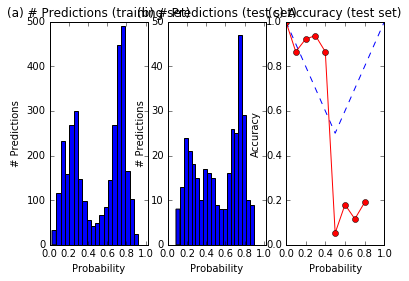

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.471947194719
----------------------------------------
Precision:	0.135135135135
Recall:		0.609756097561
F1 Score:	0.221238938053
----------------------------------------
TP: 25 | FP: 160 | TN: 143 | FN: 16
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.471947194719
Corpus Precision 0.135
Corpus Recall    0.61
Corpus F1        0.221
----------------------------------------
TP: 25 | FP: 160 | TN: 143 | FN: 16

Testing n_iter = 2.00e+03, rate = 1.78e-02, mu = 1.00e-08
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.0177827941004
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 0.0160897324558
	Loss = 10198.359228	Gradient magnitude = 710.250955
	Learning epoch = 200	Step size = 0.0145578635751
	Loss = 10347.305494	Gradient mag

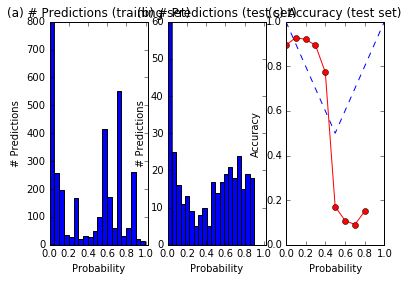

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.512195121951
Neg. class accuracy: 0.524752475248
----------------------------------------
Precision:	0.127272727273
Recall:		0.512195121951
F1 Score:	0.203883495146
----------------------------------------
TP: 21 | FP: 144 | TN: 159 | FN: 20
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.512195121951
Neg. class accuracy: 0.524752475248
Corpus Precision 0.127
Corpus Recall    0.512
Corpus F1        0.204
----------------------------------------
TP: 21 | FP: 144 | TN: 159 | FN: 20

Testing n_iter = 5.00e+02, rate = 5.62e-04, mu = 1.00e-02
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.00056234132519
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 0.00050880201503
	Loss = 1430.401289	Gradient magnitude = 92.178278
	Learning epoch = 200	Step size = 0.000460360067635
	Loss = 1406.926502	Gradient m

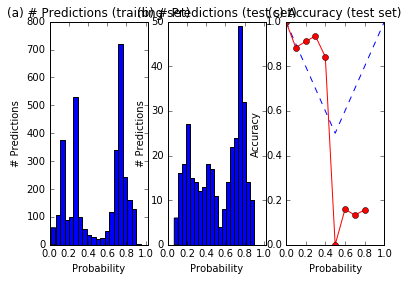

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.585365853659
Neg. class accuracy: 0.471947194719
----------------------------------------
Precision:	0.130434782609
Recall:		0.585365853659
F1 Score:	0.213333333333
----------------------------------------
TP: 24 | FP: 160 | TN: 143 | FN: 17
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.585365853659
Neg. class accuracy: 0.471947194719
Corpus Precision 0.13
Corpus Recall    0.585
Corpus F1        0.213
----------------------------------------
TP: 24 | FP: 160 | TN: 143 | FN: 17

Testing n_iter = 2.00e+03, rate = 1.78e-02, mu = 1.00e-02
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.0177827941004
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 0.0160897324558
	Loss = 6675.766367	Gradient magnitude = 1517.173637
	Learning epoch = 200	Step size = 0.0145578635751
	Loss = 5866.483824	Gradient magn

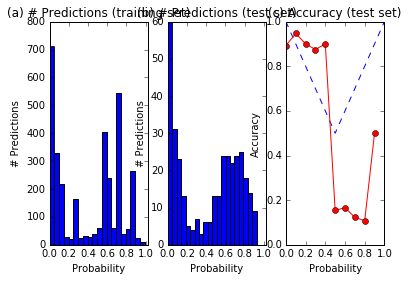

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.50495049505
----------------------------------------
Precision:	0.142857142857
Recall:		0.609756097561
F1 Score:	0.231481481481
----------------------------------------
TP: 25 | FP: 150 | TN: 153 | FN: 16
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.50495049505
Corpus Precision 0.143
Corpus Recall    0.61
Corpus F1        0.231
----------------------------------------
TP: 25 | FP: 150 | TN: 153 | FN: 16

Testing n_iter = 2.00e+03, rate = 5.62e-04, mu = 1.00e-02
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.00056234132519
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 0.00050880201503
	Loss = 1430.401289	Gradient magnitude = 92.178278
	Learning epoch = 200	Step size = 0.000460360067635
	Loss = 1406.926502	Gradient magn

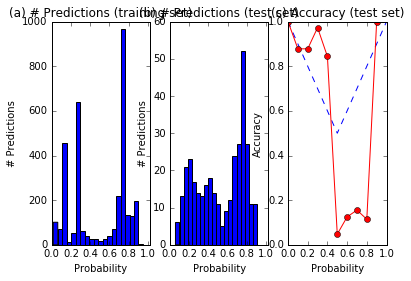

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.465346534653
----------------------------------------
Precision:	0.133689839572
Recall:		0.609756097561
F1 Score:	0.219298245614
----------------------------------------
TP: 25 | FP: 162 | TN: 141 | FN: 16
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.465346534653
Corpus Precision 0.134
Corpus Recall    0.61
Corpus F1        0.219
----------------------------------------
TP: 25 | FP: 162 | TN: 141 | FN: 16

Testing n_iter = 5.00e+02, rate = 1.00e-04, mu = 1.00e-05
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 1523.241644	Gradient magnitude = 86.202784
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 1481.426309	Gradient magnitude =

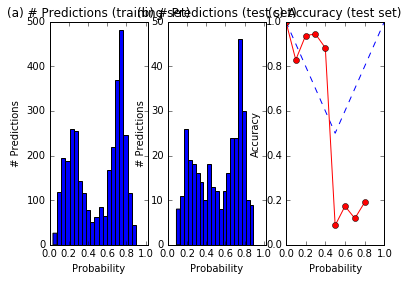

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.634146341463
Neg. class accuracy: 0.46204620462
----------------------------------------
Precision:	0.137566137566
Recall:		0.634146341463
F1 Score:	0.226086956522
----------------------------------------
TP: 26 | FP: 163 | TN: 140 | FN: 15
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.634146341463
Neg. class accuracy: 0.46204620462
Corpus Precision 0.138
Corpus Recall    0.634
Corpus F1        0.226
----------------------------------------
TP: 26 | FP: 163 | TN: 140 | FN: 15

Testing n_iter = 2.00e+03, rate = 5.62e-04, mu = 1.00e-04
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.00056234132519
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 0.00050880201503
	Loss = 1427.018962	Gradient magnitude = 92.396667
	Learning epoch = 200	Step size = 0.000460360067635
	Loss = 1402.668022	Gradient mag

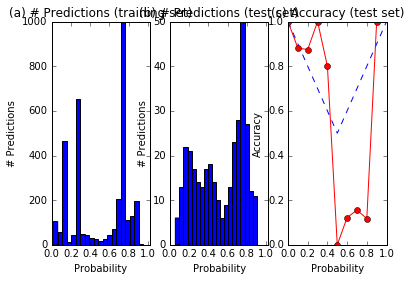

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.585365853659
Neg. class accuracy: 0.468646864686
----------------------------------------
Precision:	0.12972972973
Recall:		0.585365853659
F1 Score:	0.212389380531
----------------------------------------
TP: 24 | FP: 161 | TN: 142 | FN: 17
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.585365853659
Neg. class accuracy: 0.468646864686
Corpus Precision 0.13
Corpus Recall    0.585
Corpus F1        0.212
----------------------------------------
TP: 24 | FP: 161 | TN: 142 | FN: 17

Testing n_iter = 1.00e+03, rate = 3.16e-03, mu = 1.00e-05
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.00316227766017
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 0.00286120399391
	Loss = 1923.179759	Gradient magnitude = 690.345921
	Learning epoch = 200	Step size = 0.00258879490498
	Loss = 1705.416970	Gradient mag

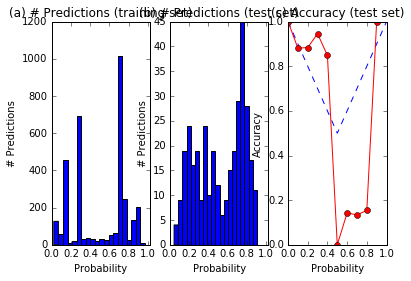

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.585365853659
Neg. class accuracy: 0.475247524752
----------------------------------------
Precision:	0.131147540984
Recall:		0.585365853659
F1 Score:	0.214285714286
----------------------------------------
TP: 24 | FP: 159 | TN: 144 | FN: 17
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.585365853659
Neg. class accuracy: 0.475247524752
Corpus Precision 0.131
Corpus Recall    0.585
Corpus F1        0.214
----------------------------------------
TP: 24 | FP: 159 | TN: 144 | FN: 17

Testing n_iter = 1.00e+03, rate = 1.00e-04, mu = 1.00e-03
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 1523.375429	Gradient magnitude = 86.224118
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 1481.625894	Gradient magnitude 

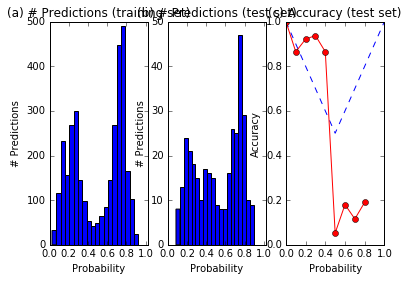

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.471947194719
----------------------------------------
Precision:	0.135135135135
Recall:		0.609756097561
F1 Score:	0.221238938053
----------------------------------------
TP: 25 | FP: 160 | TN: 143 | FN: 16
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.471947194719
Corpus Precision 0.135
Corpus Recall    0.61
Corpus F1        0.221
----------------------------------------
TP: 25 | FP: 160 | TN: 143 | FN: 16

Testing n_iter = 2.50e+02, rate = 3.16e-03, mu = 1.00e-08
Training marginals (!= 0.5):	2756
Features:			96446
Using gradient descent...
	Learning epoch = 0	Step size = 0.00316227766017
	Loss = 1910.313630	Gradient magnitude = 708.911360
	Learning epoch = 100	Step size = 0.00286120399391
	Loss = 1943.029849	Gradient magnitude = 707.572932
	Learning epoch = 200	Step size = 0.00258879490498
	Loss = 1731.332381	Gradient ma

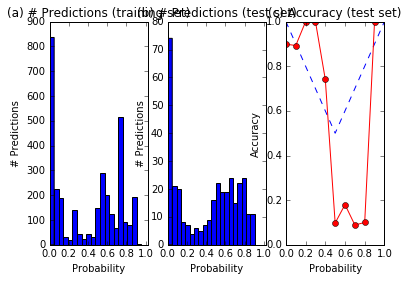

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.512195121951
Neg. class accuracy: 0.518151815182
----------------------------------------
Precision:	0.125748502994
Recall:		0.512195121951
F1 Score:	0.201923076923
----------------------------------------
TP: 21 | FP: 146 | TN: 157 | FN: 20
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.512195121951
Neg. class accuracy: 0.518151815182
Corpus Precision 0.126
Corpus Recall    0.512
Corpus F1        0.202
----------------------------------------
TP: 21 | FP: 146 | TN: 157 | FN: 20



,n_iter,rate,mu,Prec.,Rec.,F1
0,1000,0.000100,1.000000e-05,0.135135,0.609756,0.221239
1,2000,0.017783,1.000000e-08,0.127273,0.512195,0.203883
2,500,0.000562,1.000000e-02,0.130435,0.585366,0.213333
3,2000,0.017783,1.000000e-02,0.142857,0.609756,0.231481
4,2000,0.000562,1.000000e-02,0.133690,0.609756,0.219298
5,500,0.000100,1.000000e-05,0.137566,0.634146,0.226087
6,2000,0.000562,1.000000e-04,0.129730,0.585366,0.212389
7,1000,0.003162,1.000000e-05,0.131148,0.585366,0.214286
8,1000,0.000100,1.000000e-03,0.135135,0.609756,0.221239
9,250,0.003162,1.000000e-08,0.125749,0.512195,0.201923


In [71]:

L_gold_dev = label_manager.load(session, dev, "Sotera User")

gold_dev_set = session.query(CandidateSet).filter(CandidateSet.name == 'Emails Development Candidates').one()

searcher = RandomSearch(disc_model, F_train, train_marginals, 10, iter_param, rate_param, reg_param)
searcher.fit(F_dev, L_gold_dev, gold_dev_set)

In [72]:

disc_model.w.shape

(96446,)

Calibration plot:


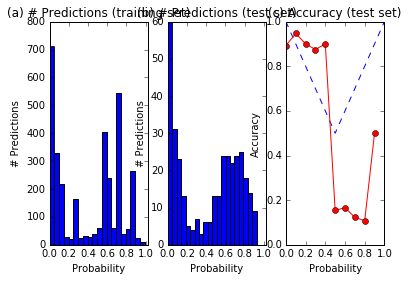

Test set size:	344
----------------------------------------
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.50495049505
----------------------------------------
Precision:	0.142857142857
Recall:		0.609756097561
F1 Score:	0.231481481481
----------------------------------------
TP: 25 | FP: 150 | TN: 153 | FN: 16
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.609756097561
Neg. class accuracy: 0.50495049505
Corpus Precision 0.143
Corpus Recall    0.61
Corpus F1        0.231
----------------------------------------
TP: 25 | FP: 150 | TN: 153 | FN: 16



In [73]:
tp, fp, tn, fn = disc_model.score(F_dev, L_gold_dev, gold_dev_set)

In [108]:
x = disc_model.predict(F_train)

In [109]:
print len(x)

3288


In [111]:
for iter,i in enumerate(x):
    if(i==1):
        print train[iter]

Person_Org(Span("Michael H. Fuchs", parent=28046, chars=[2,17], words=[1,3]), Span("U.S. Department of State", parent=28046, chars=[19,42], words=[4,7]))
Person_Org(Span("Recept Tayyip Erdogan", parent=9533, chars=[269,289], words=[48,50]), Span("Der Spiegel", parent=9533, chars=[28,38], words=[4,5]))
Person_Org(Span("Recept Tayyip Erdogan", parent=9533, chars=[269,289], words=[48,50]), Span("Spiegel Online", parent=9533, chars=[0,13], words=[0,1]))
Person_Org(Span("Obama", parent=7248, chars=[59,63], words=[11,11]), Span("Democratic", parent=7248, chars=[119,128], words=[21,21]))
Person_Org(Span("Huckabee", parent=14388, chars=[118,125], words=[30,30]), Span("Gingrich", parent=14388, chars=[151,158], words=[39,39]))
Person_Org(Span("Romney", parent=14388, chars=[184,189], words=[48,48]), Span("Daniels", parent=14388, chars=[215,221], words=[57,57]))
Person_Org(Span("Romney", parent=14388, chars=[184,189], words=[48,48]), Span("Gingrich", parent=14388, chars=[151,158], words=[39,39]))


UnicodeEncodeError: 'ascii' codec can't encode character u'\u2022' in position 21: ordinal not in range(128)

In [26]:
len(train)

3288

In [28]:
x = disc_model.predict(F_train)

In [29]:
len(x)

3288

In [30]:
print x

[ 1  1  1 ..., -1 -1  1]


In [112]:
for iter,index in enumerate(x):
    if(index==1):
        name=train[iter][0].get_span()
        org=train[iter][1].get_span()
        print name +"," + org

Michael H. Fuchs,U.S. Department of State
Recept Tayyip Erdogan,Der Spiegel
Recept Tayyip Erdogan,Spiegel Online
Obama,Democratic
Huckabee,Gingrich
Romney,Daniels
Romney,Gingrich
Rahm Emanuel,Hitlers T
McGuinness,St Andrews
Palin,Facebook
Charles Grassley,Senate Finance Committee
Liz,Keep America Safe
Philip Crowley,State Department
Hillary Rodham Clintons,State
Biden,MSNBC
Mark Sedwill,NATO
Chernick,Fairtmook Foundation
David H. Petraeus,U.S. Central Command
Obama,Defense
Rahm Emanuel,White House
Jalil,NTC
Karzai,Walter Reed Army Medical Center
Obama,Congress
Ali Tarhouni,Muslim Brotherhood
DeMint,Foreign Relations Committee
Robinson,BBC
John Manion,NENA
Brooke Shearer,International Center for Research of Women
Brooke Shearer,ICRW
Melanne S. Verveer,Global Women's Issues U.S. Department
Carter,CNN
Reagan,Ford
Ralph Nader,Dow Chemical
Powell,U.S. Chamber of Commerce
Fezzan,GNC
Fezzan,Tripolitania
Koch,Center for Public Integrity
Netanyahu,Washington Post
Netanyahu,Obamas
Judith,Muslim
